In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
# import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import mnist
from sklearn.preprocessing import OneHotEncoder

2023-11-14 05:40:50.592100: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-14 05:40:51.617858: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
from tensorflow.python.client import device_lib
print('Available GPUs')
for d in device_lib.list_local_devices():
    print(d.physical_device_desc)

Available GPUs



2023-11-14 05:40:52.983774: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [3]:
# import the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

print('Training set dims', x_train.shape, y_train.shape)
print('Testing set dims', x_test.shape, y_test.shape)

Training set dims (60000, 28, 28) (60000,)
Testing set dims (10000, 28, 28) (10000,)


image data [[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   3  18  18  18 126 136
  175  26 166 255 247 127   0   0   0   0]
 [  0   0   0   0   0   0   0   0  30  36  94 154 170 253 253 253 253 253
  225 172 253 242 195  64   0   0   0   0]
 [  0   0   0   0   0   0   0  49 238 253 253 253 253 253 253 253 253 251
   93  82  82  56  39   0   0   0   0   0]
 [  0   0   0   0   0   0   0  18 219 253 253 253 253

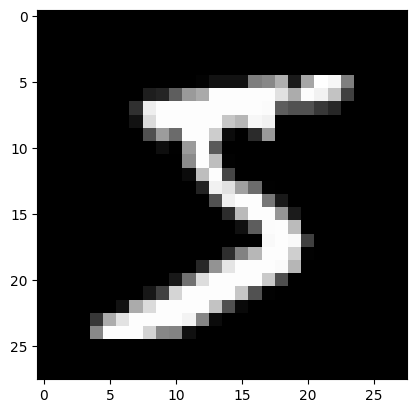

In [4]:
imageId = 0
print('image data',x_train[imageId])
print('image label', y_train[imageId])
# plot the sample

fig = plt.figure
plt.imshow(x_train[imageId], cmap='gray')
plt.show()

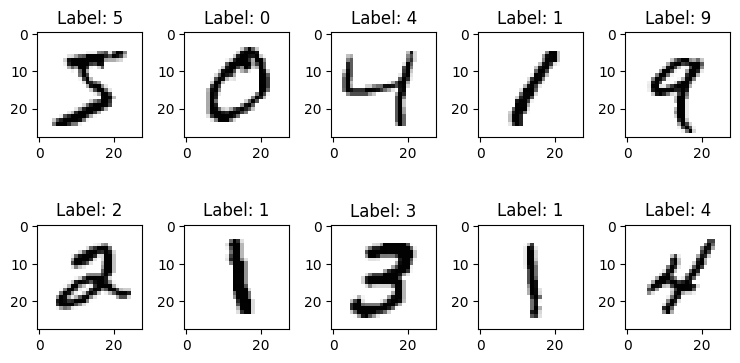

In [5]:
num_row = 2
num_col = 5
startImageId = 0

fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
for i in range(num_row*num_col):
    ax = axes[i//num_col, i%num_col]
    ax.imshow(x_train[i+startImageId], cmap='gray_r')
    ax.set_title('Label: {}'.format(y_train[i+startImageId]))
plt.tight_layout()
plt.show()

In [6]:
# Flatten each figure into a linear sequence of 784 pixels

n_figs = x_train.shape[0]
x_train = x_train.reshape(n_figs, 784)
n_figs = x_test.shape[0]
x_test = x_test.reshape(n_figs, 784)

# Convert each pixel from 0..255 into a [0, 1] interval (it it the equivalent of ScandarScaler)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

# and OneHot enconding the target value
enc = OneHotEncoder()
Y_train = enc.fit_transform(y_train[:, np.newaxis]).toarray()


In [7]:
imageId=10

y_train[imageId], Y_train[imageId]

(3, array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]))

In [8]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense

classifier = Sequential()
# Hidden Layer (using implict input layer)
classifier.add(Dense(32, activation='sigmoid', kernel_initializer='random_normal', input_dim=784, name='HiddenLayer'))
# Output Layer
classifier.add(Dense(10, activation='softmax', kernel_initializer='random_normal', name='OutputLayer'))

# Compiling & fitting the neural network
classifier.compile(optimizer ='adam', loss='binary_crossentropy', metrics =['accuracy'])

### Adam optimization is an extension to Stochastic gradient decent

See:

https://optimization.cbe.cornell.edu/index.php?title=Adam

https://www.geeksforgeeks.org/intuition-of-adam-optimizer

https://arxiv.org/pdf/1412.6980.pdf

In [9]:
print('data size:', x_train.shape[0], ' samples of ',x_train.shape[1], 'pixels')

classifier.summary()

data size: 60000  samples of  784 pixels
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 HiddenLayer (Dense)         (None, 32)                25120     
                                                                 
 OutputLayer (Dense)         (None, 10)                330       
                                                                 
Total params: 25450 (99.41 KB)
Trainable params: 25450 (99.41 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [10]:
# number od coefficients input-->hidden layer
print(784*32  + 32)
# number of coefficients hidden layer--> output
print(32*10+10)

25120
330


In [11]:
from  tensorflow.keras.utils import plot_model
plot_model(classifier, show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [12]:
# using the full gradient descent
# history = classifier.fit(x_train, Y_train, epochs=20)
# using the mini batch gradient descent
history = classifier.fit(x_train, Y_train, batch_size=128, epochs=20)

Epoch 1/20
469/469 [==============================] - 1s 1ms/step - loss: 0.3178 - accuracy: 0.4083
Epoch 2/20
469/469 [==============================] - 1s 1ms/step - loss: 0.1963 - accuracy: 0.8032
Epoch 3/20
469/469 [==============================] - 1s 2ms/step - loss: 0.1256 - accuracy: 0.8818
Epoch 4/20
469/469 [==============================] - 1s 2ms/step - loss: 0.0910 - accuracy: 0.9020
Epoch 5/20
469/469 [==============================] - 1s 2ms/step - loss: 0.0735 - accuracy: 0.9111
Epoch 6/20
469/469 [==============================] - 1s 2ms/step - loss: 0.0634 - accuracy: 0.9170
Epoch 7/20
469/469 [==============================] - 1s 2ms/step - loss: 0.0569 - accuracy: 0.9218
Epoch 8/20
469/469 [==============================] - 1s 2ms/step - loss: 0.0523 - accuracy: 0.9261
Epoch 9/20
469/469 [==============================] - 1s 2ms/step - loss: 0.0488 - accuracy: 0.9297
Epoch 10/20
469/469 [==============================] - 1s 2ms/step - loss: 0.0460 - accuracy: 0.9327

1/1 [==============================] - 0s 108ms/step


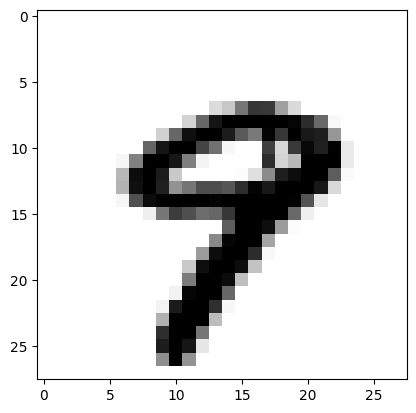

,digit,prob
0,0,8.181027e-07
1,1,2.958913e-06
2,2,9.565183e-07
3,3,2.737544e-06
4,4,3.491448e-03
5,5,4.775218e-06
6,6,1.351749e-06
7,7,4.603642e-04
8,8,3.348039e-05
9,9,9.960011e-01


In [13]:
imageId=9

yp=classifier.predict(x_test[imageId].reshape(-1,784))

fig = plt.figure
plt.imshow(x_test[imageId].reshape(28,28), cmap='gray_r')
plt.show()

yp_table = pd.DataFrame(np.arange(0,10), columns=['digit'])
yp_table['prob'] = np.transpose(yp)

yp_table

In [14]:
np.argmax(yp)

9

In [21]:
history.history

{'loss': [0.31783410906791687,
  0.1963377296924591,
  0.12559644877910614,
  0.09103131294250488,
  0.07346784323453903,
  0.06341618299484253,
  0.05691378563642502,
  0.052275124937295914,
  0.04875938221812248,
  0.045961298048496246,
  0.043701376765966415,
  0.04179329052567482,
  0.040120434015989304,
  0.03865749388933182,
  0.03730402886867523,
  0.03609531745314598,
  0.03506386652588844,
  0.03408967703580856,
  0.033178165555000305,
  0.03235883265733719],
 'accuracy': [0.40826666355133057,
  0.8032000064849854,
  0.8818166851997375,
  0.9019500017166138,
  0.9110833406448364,
  0.9169833064079285,
  0.921750009059906,
  0.9260666370391846,
  0.9297166466712952,
  0.9327166676521301,
  0.9361666440963745,
  0.9384499788284302,
  0.9407333135604858,
  0.9431333541870117,
  0.9449666738510132,
  0.9471833109855652,
  0.9486833214759827,
  0.9502333402633667,
  0.9519500136375427,
  0.9528499841690063]}

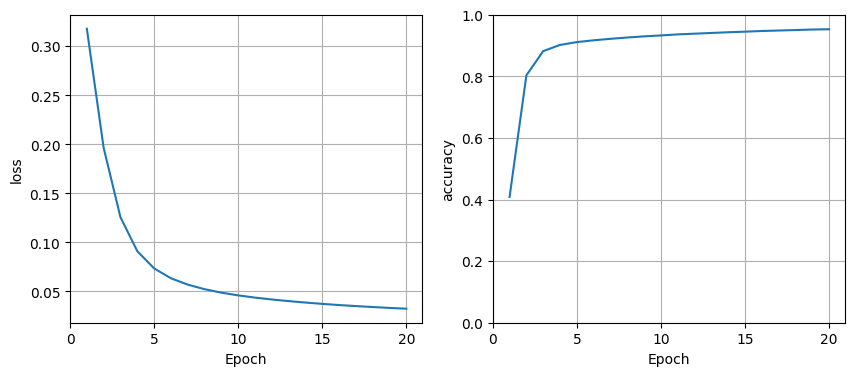

In [39]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
# plt.plot(history.history['loss'])
plt.plot(np.arange(1,21,1), history.history['loss'])
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.xticks([0,5,10,15,20])
plt.grid()
plt.subplot(1,2,2)
plt.plot(np.arange(1,21,1),history.history['accuracy'])
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.xticks([0,5,10,15,20])
plt.ylim(0,1)
plt.grid()

In [15]:
y_pred = np.argmax(classifier.predict(x_test), axis=1)

313/313 [==============================] - 0s 917us/step


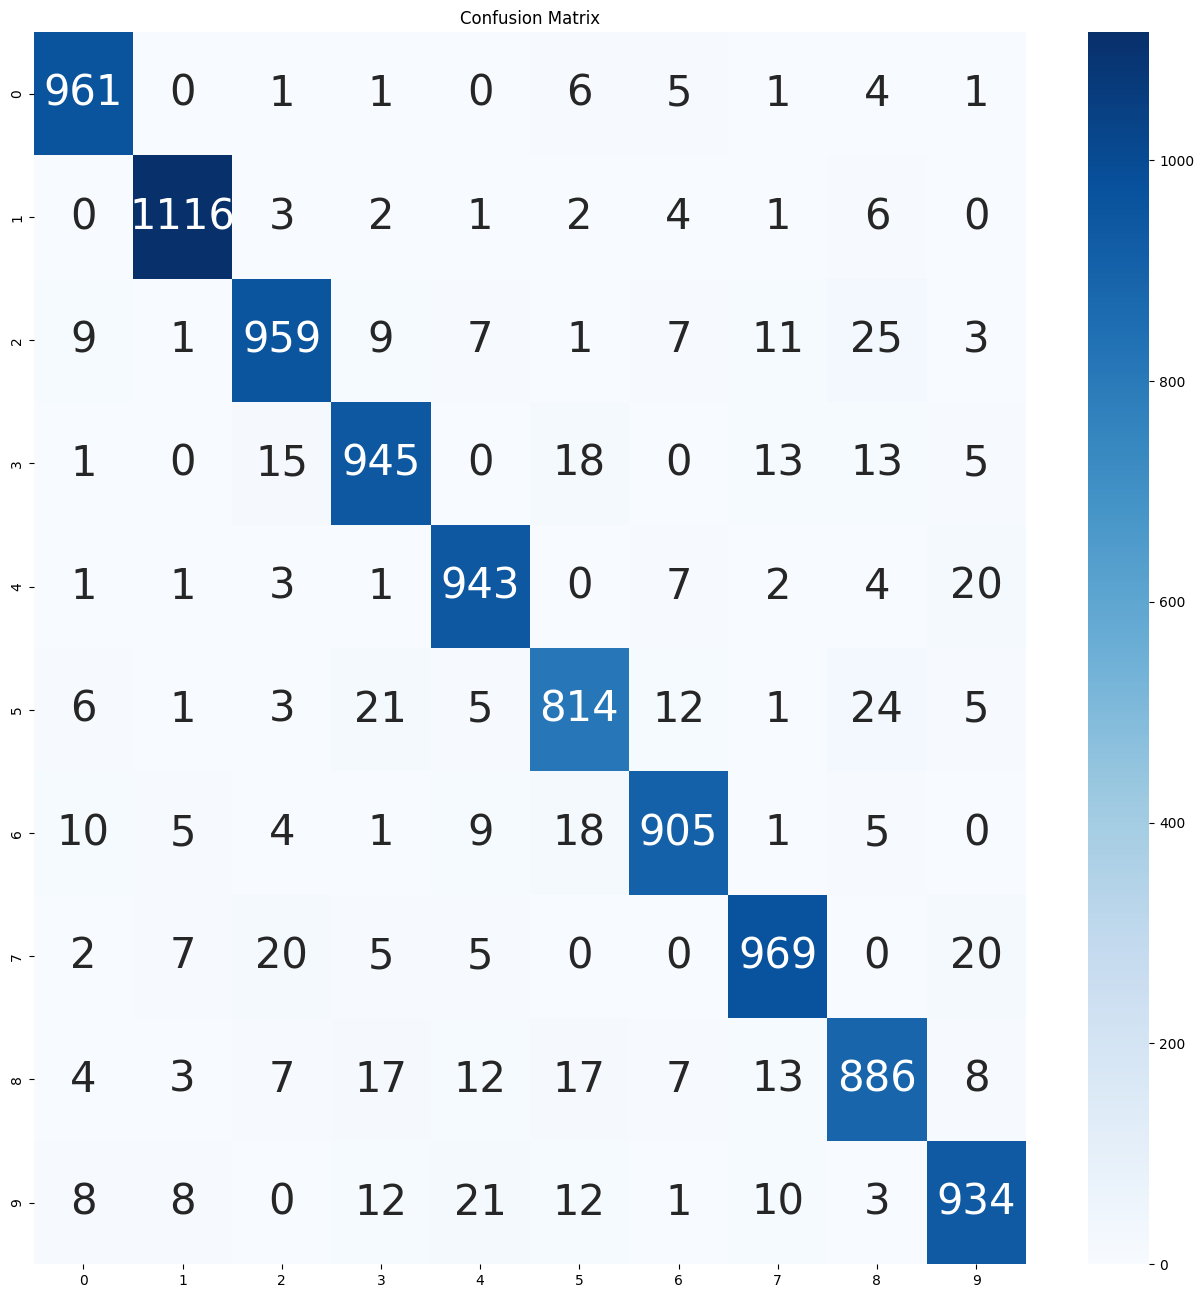

In [16]:
cm = confusion_matrix(y_test,y_pred)

plt.figure(figsize=(16,16))
ax = plt.axes()
sns.heatmap(cm, annot=True, annot_kws={"size": 30}, fmt='d',cmap="Blues", ax = ax )
ax.set_title('Confusion Matrix')
plt.show()

In [17]:
Y_test = enc.transform(y_test[:, np.newaxis]).toarray()

scores = classifier.evaluate(x_test, Y_test)

for i in range(len(classifier.metrics_names)):
    print(classifier.metrics_names[i], scores[i])

313/313 [==============================] - 0s 843us/step - loss: 0.0367 - accuracy: 0.9432
loss 0.0367189384996891
accuracy 0.9431999921798706


In [18]:
np.where(y_pred != y_test)

(array([   8,   66,  149,  193,  217,  233,  241,  247,  259,  290,  300,
         305,  318,  320,  321,  325,  340,  352,  362,  381,  445,  448,
         478,  479,  495,  507,  531,  543,  551,  565,  569,  578,  582,
         583,  591,  613,  628,  658,  659,  691,  707,  717,  720,  728,
         740,  741,  760,  839,  844,  877,  924,  938,  939,  947,  950,
         951,  956,  965,  975,  982, 1003, 1014, 1032, 1039, 1062, 1068,
        1107, 1112, 1114, 1124, 1128, 1153, 1166, 1181, 1182, 1192, 1194,
        1198, 1202, 1204, 1208, 1226, 1232, 1233, 1242, 1247, 1256, 1260,
        1283, 1289, 1299, 1319, 1325, 1326, 1337, 1364, 1378, 1393, 1415,
        1433, 1436, 1444, 1500, 1522, 1527, 1530, 1549, 1553, 1559, 1569,
        1581, 1587, 1601, 1609, 1626, 1634, 1640, 1641, 1678, 1681, 1686,
        1709, 1717, 1722, 1732, 1737, 1751, 1754, 1772, 1773, 1790, 1800,
        1813, 1868, 1878, 1883, 1901, 1917, 1938, 1941, 1952, 1955, 1970,
        1973, 1981, 1982, 1984, 2004, 

ground truth 7  predicted label 2


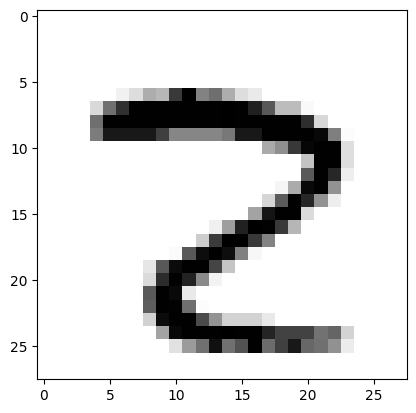

In [19]:
imageId = 2044

print(f"ground truth {y_pred[imageId]}  predicted label {y_test[imageId]}") 

plt.imshow(x_test[imageId].reshape(28,28), cmap='gray_r')
plt.show()